In [45]:
#Reading in the necessary packages (see Merger-Playground for plotting capabilities)
!pip install netCDF4

import numpy as np
import netCDF4 as nc
import h5py
import pandas as pd
from datetime import datetime
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm,colors
from matplotlib.colors import ListedColormap

In [46]:
#Constants and file path locations
#data_month = 'March'
#dx = 0.5 

#data_loc = 'C:/Users/jamie/Documents/Oklahoma/Modules/Radar/'

#data 1: 'OR_GLM-L2-LCFA_G16_s20210841745000_e20210841745203_c20210841745215.nc'

In [47]:
#Taking the given file path and grabbing the lat and lons of the GLM flashes
def GLM_data_setup(file):
    dset = nc.Dataset(file)
    
    GLM_lats = dset.variables['flash_lat'][:]
    GLM_lons = dset.variables['flash_lon'][:]
    
    dset.close()
    
    return GLM_lats, GLM_lons


In [48]:
#nc.Dataset(data_loc)
GLM_lat1,GLM_lon1=GLM_data_setup('OR_GLM-L2-LCFA_G16_s20210841745000_e20210841745203_c20210841745215.nc')
GLM_lat2,GLM_lon2=GLM_data_setup('OR_GLM-L2-LCFA_G16_s20210841745200_e20210841745403_c20210841745425.nc')
GLM_lat3,GLM_lon3=GLM_data_setup('OR_GLM-L2-LCFA_G16_s20210841745400_e20210841746003_c20210841746023.nc')

GLM_lat=np.concatenate((GLM_lat1, GLM_lat2, GLM_lat3))
GLM_lon=np.concatenate((GLM_lon1, GLM_lon2, GLM_lon3))




In [49]:
#This function makes a target grid using our defined spacing
def grid_maker(dx):
    #Establishing the grid points in a 1-D and 2-D array
    lat_pts = np.arange(30,36.75,dx)
    lon_pts = np.arange(-120,-79.75,dx)
    lon_grid, lat_grid = np.meshgrid(lon_pts, lat_pts)
    
    #Will be used in the grid accumulation part later
    lat_index = np.arange(0,len(lat_pts))
    lon_index = np.arange(0,len(lon_pts))
    
    #Getting the target grids for LIS and PR data
    target_grid_GLM = np.ones(lon_grid.shape)*np.nan
    target_grid_prns = np.ones(lon_grid.shape)*np.nan
    
    return lat_pts, lon_pts, lon_grid, lat_grid, lat_index, lon_index, target_grid_GLM, target_grid_prns

In [50]:
lat_pts, lon_pts, lon_grid, lat_grid, lat_index, lon_index, target_grid_GLM, target_grid_prns= grid_maker(dx)

In [51]:
#Accumulating the GLM data to the target grid on a point-by-point basis
def ltg_grid_accum(lat_index, lon_index, GLM_lats, GLM_lons, dx, target_grid_GLM):
    
    #Outer loop for looping through the defined latitudes
    for i in lat_index[:]:
        #Inner loop for looping through the defined longitudes
        for j in lon_index[:]:
            #Finding where the GLM points fall within the defined bounds
            GLM_points = np.where((GLM_lats < lat_pts[i]+(dx/2))&
                                  (GLM_lats >= lat_pts[i]-(dx/2))&
                                  (GLM_lons < lon_pts[j]+(dx/2))&
                                  (GLM_lons >= lon_pts[j]-(dx/2)))[0]

            #If we find flashes in the searched domain, add the count to the target grid
            if len(GLM_points)>0:
                target_grid_GLM[i,j] = len(GLM_points)
    
    return target_grid_GLM

In [52]:
target_grid_GLM=ltg_grid_accum(lat_index, lon_index, GLM_lat, GLM_lon, dx, target_grid_GLM)

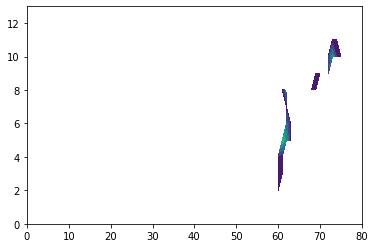

In [53]:
plt.contourf(target_grid_GLM)

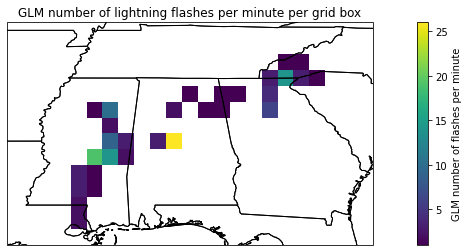

In [70]:
fig1 = plt.figure(figsize=(16,9))
ax1 = plt.subplot(2,1,1, projection=ccrs.PlateCarree())
#a = ax1.contourf(pr_lon[:],pr_lat[:],pr_lat[:])
#ax1.scatter(lis_lons[:],lis_lats[:],transform=pc_proj, s=0.3,color='r')
#ax1.contourf(lon_pts, lat_pts, target_grid)
a = ax1.imshow(target_grid_GLM[::-1,:], extent=[-120.25,-79.75,29.75,36.75])
ax1.add_feature(cfeature.STATES)
#a = ax1.contourf(_lon[:],pr_lat[:],pr_lat[:])
#ax1.set_extent([-120,-80,30,36.5])
ax1.set_xlim(-92.25,-80.75)
ax1.set_ylim(29.75,36.75)
plt.title('GLM number of lightning flashes per minute per grid box')
#cbar.set_label('Flashes per minute')
ax1.coastlines()
#cbar = fig.colorbar(fig1) # add a colorbar
#cbar.set_label('Divergence (s$^{-1}$)')
plt.colorbar(a, label='GLM number of flashes per minute') #number of flashes per minute in a grid box


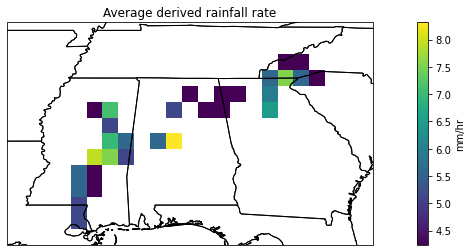

In [68]:
Rainfall_rate = 2.88 * np.log10(target_grid_GLM) + 4.24 #average rainfall rate(mm/hr) from table

fig = plt.figure(figsize=(16,9))
ax1 = plt.subplot(2,1,1, projection=ccrs.PlateCarree())
#a = ax1.contourf(pr_lon[:],pr_lat[:],pr_lat[:])
#ax1.scatter(lis_lons[:],lis_lats[:],transform=pc_proj, s=0.3,color='r')
#ax1.contourf(lon_pts, lat_pts, target_grid)
a = ax1.imshow(Rainfall_rate[::-1,:], extent=[-120.25,-79.75,29.75,36.75])
ax1.add_feature(cfeature.STATES)
#a = ax1.contourf(_lon[:],pr_lat[:],pr_lat[:])
#ax1.set_extent([-120,-80,30,36.5])
ax1.set_xlim(-92.25,-80.75)
ax1.set_ylim(29.75,36.75)
plt.title('Average derived rainfall rate')
ax1.coastlines()
plt.colorbar(a, label='mm/hr')

In [ ]:
GLM_flist = sorted(os.listdir(lis_data_loc))
pr_flist = sorted(os.listdir(pr_data_loc))

findex = np.arange(0,len(lis_flist),1)

#Loop that reads through each file (as long as the data matches)

for i in findex:
    #Selecting the file name from the list
    GLM_file = GLM_flist[i]
    pr_file = pr_flist[i]
    
    #Checking that the files are matching
    GLM_op_num = GLM_file[-8:-3]
    pr_op_num = pr_file[-15:-10]
    
    if GLM_op_num != pr_op_num:
        print ('---ERROR: FILE MISMATCH---')
        print ('GLM Overpass: '+GLM_op_num)
        print ('PR  Overpass: '+pr_op_num)
        #quit()
    
    print ('--------------------------')
    print ('GLM Overpass: '+GLM_op_num)
    print ('PR  Overpass: '+pr_op_num)
    
    #Reading in the data
    GLM_lats, GLM_lons = GLM_data_setup(GLM_data_loc+lGLM_file)
    pr_lat, pr_lon, prns, cur_time, cur_time_str = pr_data_setup(pr_data_loc+pr_file)
    
    #Setting up the target grid we'll accumualte our data on
    lat_pts, lon_pts, lon_grid, lat_grid, lat_index, lon_index, target_grid_GLM, target_grid_prns= grid_maker(dx)
    
    #Accumulating our GLM flashes to the target grid
    target_grid_GLM = ltg_grid_accum(lat_index, lon_index, GLM_lats, GLM_lons, dx, target_grid_GLM)
    
    #Placing the local max rainfall rate on the target grid
    target_grid_pr = pr_grid_accum(lat_index, lon_index, pr_lat, pr_lon, lat_pts, lon_pts, dx, target_grid_prns, prns)
    
    #Truning the target grids, lats, lons, and time into a dataframe
    df = df_maker(target_grid_prns, target_grid_GLM, lon_grid, lat_grid, cur_time)
    
    #Saving the file out (if it has data)
    
    if df.shape[0] > 0:
        df.to_pickle(output_loc+cur_time_str+'-'+GLM_op_num+'.pkl')
    
    print ('Index: '+str(i)+'/'+str(findex[-1]))
    print ('Data points: '+str(df.shape[0]))